In [1]:
#Importing necessary Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from setuptools.command.install import install

In [2]:
#Uploading data using False low_memory to detect and handle different types of inputs in the columns
#A copy of the raw data file is used to prevent damage of original information
roads= pd.read_csv("/Users/precupada/Advanced-Simulation---Group-12/data/_roads_1.tsv", sep='\t', low_memory=False)
bridges=pd.read_excel("/Users/precupada/Advanced-Simulation---Group-12/data/BMMS_overview_1.xlsx")

# Roads file: Resolving Distances between LRP points

This part of the code will focus on the _"_roads.tsv"_ file and implement a solution to eliminate noise from the data and ultimately improve the simulation output. 

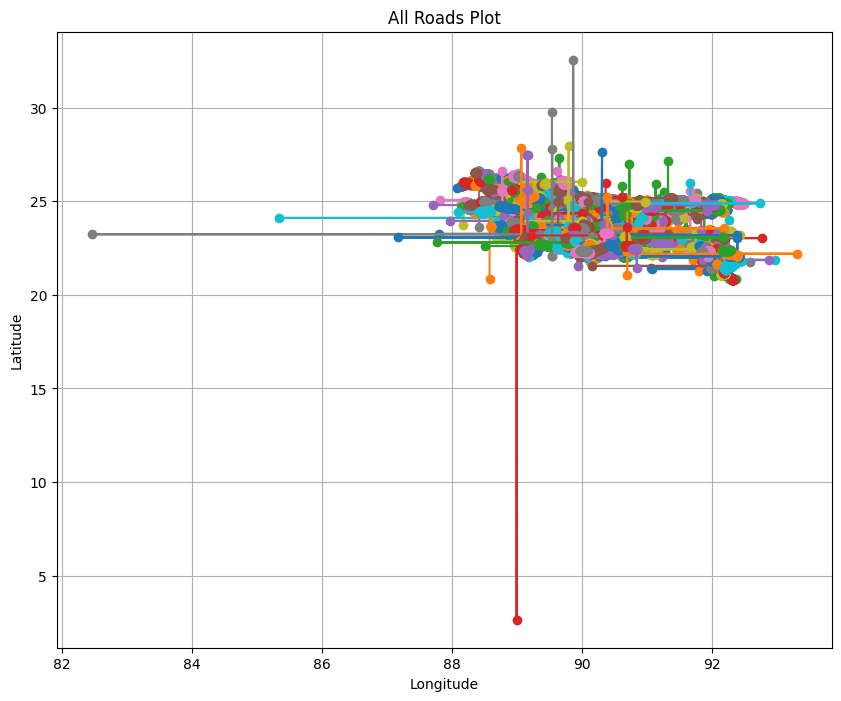

In [3]:
# Vizualizing the data
# Create a plot
plt.figure(figsize=(10, 8))

# Loop through each row in the dataframe (each road)
for index, row in roads.iterrows():
    # Extract the name of the road (first column)
    road_name = row.iloc[0]
    
    # Extract latitude and longitude values from the row
    latitudes = []
    longitudes = []
    
    # Extract latitude and longitude for each LRP, assuming columns are in a pattern
    for i in range(1, len(row), 3):  # every 3rd column is latitude and longitude
        latitudes.append(row.iloc[i+1])   # Column i+1 is latitude
        longitudes.append(row.iloc[i+2])  # Column i+2 is longitude
    
    # Plot the road (connecting the points)
    plt.plot(longitudes, latitudes, marker='o', label=f'{road_name}')

# Customize the plot
plt.title('All Roads Plot')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)


# Show the plot
plt.show()

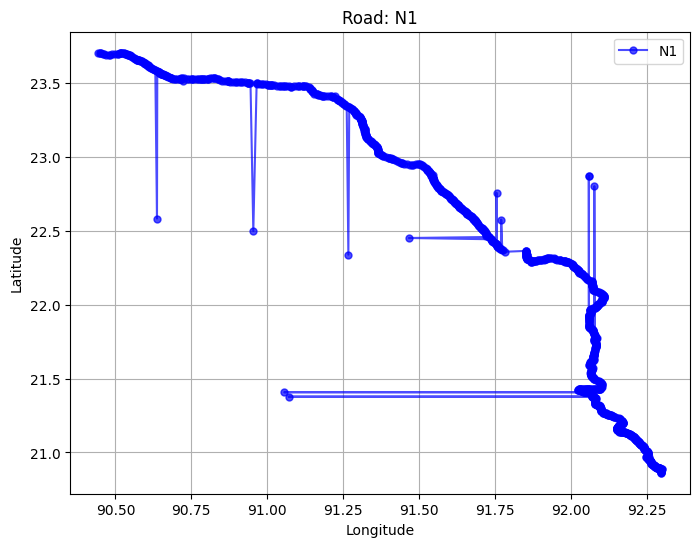

In [4]:
# Zooming into one road to take a closer look at the outliers shown in the "All roads plot" 
# Select the first row from the dataframe
row = roads.iloc[0]

# Extract the name of the road (first column)
road_name = row.iloc[0]

# Extract latitude and longitude values from the row
latitudes = []
longitudes = []

# Extract latitude and longitude for each LRP
for i in range(1, len(row), 3):  # every 3rd column is latitude and longitude
    latitudes.append(row.iloc[i+1])   # Column i+1 is latitude
    longitudes.append(row.iloc[i+2])  # Column i+2 is longitude

# Create the plot
plt.figure(figsize=(8, 6))

# Plot the road (first row)
plt.plot(longitudes, latitudes, marker='o', markersize=5, linestyle='-', color='blue', alpha=0.7, label=f'{road_name}')

# Customize the plot
plt.title(f'Road: {road_name}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

## Creating a distance function
To clean up the roads.tsv file and ensure continuity of the roads, we have to eliminate outliers amongst the LRPs for each road. To do this, we create a function that calculates the distances between the LRPs of one specific highway. We hope to eventually eliminate those LRPs that deviate too much from the average distance.

In [5]:
# Defining the function
def find_distance(row):
    latitudes = []
    longitudes = []
    distances = np.array([])
    
    # The iteration jumps in 3 columns every run, starting column 1)
    for i in range(1, len(row),3):
        latitudes.append(row.iloc[i+1])
        longitudes.append(row.iloc[i+2])

    # Creating an iteration to calculate the distance between two LRP using Pythagoras theorem
    # The iterator starts at 1 to be able to access the previous point using j-1
    for j in range (1, len(latitudes)):
        distance= np.sqrt((latitudes[j]-latitudes[j-1])**2 + (longitudes[j]-longitudes[j-1])**2)
        distances= np.append(distances, distance)
        
    return distances

    

[7.73677897e-03 1.49577605e-04 1.63039664e-03 ... 3.65355402e-04
 1.69813823e-03 5.55000000e-05]


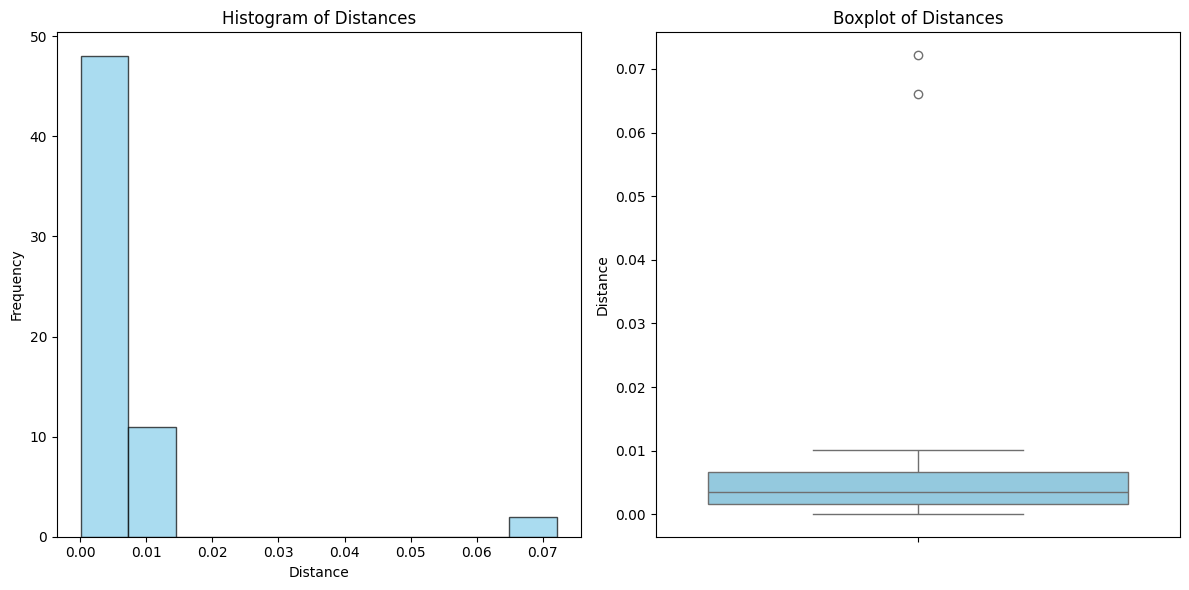

In [11]:
# Testing the function on N1 road (and others) and seeing if distribution is somewhat normal, but it is not. 
# Feel free to change the index in line 4 to test other roads
import seaborn as sns
distances_row = find_distance(roads.iloc[659])
print(distances_row_N1)
# Create a figure and axis
plt.figure(figsize=(12, 6))

# Plotting histogram to see the distribution
plt.subplot(1, 2, 1)  # (rows, columns, position)
plt.hist(distances_row, bins=10, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Histogram of Distances")
plt.xlabel("Distance")
plt.ylabel("Frequency")

# Plotting box plot to identify outliers
plt.subplot(1, 2, 2)
sns.boxplot(data=distances_row, color='skyblue')
plt.title("Boxplot of Distances")
plt.ylabel("Distance")

# Show the plots
plt.tight_layout()
plt.show()


## Identifying Outliers
To identify outliers, we employ the use of percentiles to identify which LRPs deviate too much from the majority of differences. This method is preferred over standard deviation as the distribution is not normal in the roads. The correlation between the arrays is as follows:
[ ] The index in the latitudes and longitudes arrays correspond to index + 1, and index +2 n the row of roads [], respectively.
[ ] The index in the distances array corresponds to the distance between index and index +1 in the latitudes and longitudes arrays.
[ ] If an LRP is an outlier, two consecutive distances in the distances array will be outliers. Thus, two consecutive indexes will be stored in outliers_index array. This way we can check for outliers every two indexes in the outliers_index array. 
[ ] The index of the outliers stored in the outlier_index array correspond to the indexes in the distances array. This means that the index in the outlier_index array corresponds to the index+1 in the latitudes and longitudes arrays. 
[ ] In the end, index+1 in the latitudes array corresponds to the LRP at roads.iloc[index] in the roads dataframe. This means that the index found in the outlier_index array corresponds to the index in the roads dataframe for the LRPs that are outliers. 

For example, say we take the data from the first 4 LRPs of the N1 road. The latitude and longitudes array will look like this (LRP 0,1,2,3): 
- [a,b,c,d]
- [e,f,g,h]

The distances array will look like this:
$\left[\sqrt{(b-a)^2 + (f-e)^2}, \sqrt{(c-b)^2 + (g-f)^2}, \sqrt{(d-c)^2 + (h-g)^2}\right]$

If LRP2 (c,g) is an outlier, distances at positions 1 and 2 will be outliers, and the outliers_index array will look like this: [1,2].

Since we check the outliers_index array in a step of two, we will see the selected index wil be 1. The 1 from this array, corresponds to position 1+1 in the latitudes and longitudes arrays. This means that the outlier is LRP2 (c,g) and its index in the roads dataframe is 1.


 

In [27]:

def find_outlier(distances):   
    # Finding the outliers
    outliers_index = []
    outliers_latitude = []
    outliers_longitude = [] 
    limit = np.percentile(distances,20)  # Adjust the percentile value as needed
    print (limit) #delete later, used for debugging
    for i in range(len(distances)):
        if distances[i] > limit:
            outliers_index.append(i)

    #Store longitutes and latitudes that need to be eliminated form dataset to clear discontinuities
    
    for outlier_LRP in (outliers_index):
        print(f'Outlier found at index {outlier_LRP}. Corresponds to LRP with longitude{roads.iloc[outlier_LRP*3+1]} and latitude {roads.iloc[outlier_LRP*3+2]}')
        outliers_latitude.append(roads.iloc[outlier_LRP*3+1]) # Multiply by 3 to take into account the 3 columns per LRP
        outliers_longitude.append(roads.iloc[outlier_LRP*3+2]) 
        
    return outliers_index, outliers_latitude, outliers_longitude
 #So far everything is returning empty :)   

In [28]:
#Testing the function on an individual road
find_distance(roads.iloc[0])
print (distances_row) #delte later, but right now some distances are returning nan and this is impacting the find outlier function
find_outlier(distances_row)

[0.0001112 0.0661105 0.0721451 ...       nan       nan       nan]
nan


([], [], [])

In [31]:
#testing the find_outliers fucntion on a made up dataset
#It works :) so as soon as I fix the nan issue in distances it should work
test_data= np.array([ 7.87933335,  3.96690776,  1.20005889,  4.08106555,  9.0945608 ,
  6.24926475,  9.56687429,  2.04267342,  2.94189448,  5.54273577,
  8.66454794,  1.98329573,  2.03864279,  9.12630919,  1.09260143,
  9.5752253 ,  1.47606925,  9.35662125,  9.15188057,  9.05969162,
  7.29861896,  2.83379218,  2.81683824,  9.37257181,  9.19355721,
  8.39165449,  3.66811323,  8.41380903,  7.12615618,  9.27155382,
  3.20924606,  9.32447007,  7.91317994,  4.48005306,  2.8679023 ,
  4.72825505,  9.82844162,  8.71447804,  7.96209059,  3.96110497,
  7.29246835,  3.82898598,  6.20188668,  6.01289019,  4.28981876,
  6.85110954,  7.292056  ,  3.14969986,  9.81320412,  3.56321965,
  6.94331824,  1.24059123,  8.7137695 ,  6.12000909,  2.58015218,
  9.03457212,  9.40851736,  6.53592192,  2.88369518,  9.49166568,
  4.24520427,  2.0209155 ,  5.05715876,  8.94493934,  7.52394918,
  3.07112378,  5.05546684,  4.29700848,  5.00867744,  3.95829409,
  7.88646739,  5.63675517,  5.80670675,  5.31032564,  5.26111614,
  3.72993747,  2.12403482,  8.10681961,  5.97076286,  1.06158609,
  3.0695829 ,  7.62114897,  1.21930559,  1.75517103,  9.73531438,
  2.89574156,  8.34710458,  7.22402646,  5.2670128 ,  2.20312249,
  9.07012024,  7.62115936,  4.06148188,  1.27004129,  5.10740386,
  7.42073512,  6.87517948,  9.02588805,  9.06501345,  8.39061373,
  50.        , 55.        , 60.        ])

find_outlier(test_data)

2.9929698480000004
Outlier found at index 0. Corresponds to LRP with longituderoad                  N101
lrp1                  LRPS
lat1             23.454139
lon1             91.212861
lrp2                 LRPSa
                   ...    
Unnamed: 4040          NaN
Unnamed: 4041          NaN
Unnamed: 4042          NaN
Unnamed: 4043          NaN
Unnamed: 4044          NaN
Name: 1, Length: 4045, dtype: object and latitude road                  N102
lrp1                  LRPS
lat1             23.478972
lon1             91.118194
lrp2                 LRPSa
                   ...    
Unnamed: 4040          NaN
Unnamed: 4041          NaN
Unnamed: 4042          NaN
Unnamed: 4043          NaN
Unnamed: 4044          NaN
Name: 2, Length: 4045, dtype: object
Outlier found at index 1. Corresponds to LRP with longituderoad                  N104
lrp1                  LRPS
lat1             23.009667
lon1             91.399416
lrp2                 LRPSa
                   ...    
Unnamed: 4040       

([0,
  1,
  3,
  4,
  5,
  6,
  9,
  10,
  13,
  15,
  17,
  18,
  19,
  20,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  52,
  53,
  55,
  56,
  57,
  59,
  60,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  77,
  78,
  80,
  81,
  84,
  86,
  87,
  88,
  90,
  91,
  92,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102],
 [road                  N101
  lrp1                  LRPS
  lat1             23.454139
  lon1             91.212861
  lrp2                 LRPSa
                     ...    
  Unnamed: 4040          NaN
  Unnamed: 4041          NaN
  Unnamed: 4042          NaN
  Unnamed: 4043          NaN
  Unnamed: 4044          NaN
  Name: 1, Length: 4045, dtype: object,
  road                  N104
  lrp1                  LRPS
  lat1             23.009667
  lon1             91.399416
  lrp2                 LRPSa
       